In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
import tensorflow as tf
print("Tensorflow version:", tf.__version__)


Tensorflow version: 2.15.0


FER-2013 dataset from kaggle


In [2]:
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/"+expression)))+" " + "images")

3995 images
436 images
4097 images
7215 images
4965 images
4830 images
3171 images


### Task 3: Generate Training and Validation Batches

In [3]:
img_size=48
batch_size=64
datagen_train=ImageDataGenerator(horizontal_flip=True)
train_generator=datagen_train.flow_from_directory("train/",target_size=(img_size,img_size),color_mode='grayscale',
                                                 batch_size=batch_size,class_mode='categorical',shuffle=True)
datagen_val=ImageDataGenerator(horizontal_flip=True)
validation_generator=datagen_train.flow_from_directory("test/",target_size=(img_size,img_size),color_mode='grayscale',
                                                 batch_size=batch_size,class_mode='categorical',shuffle=True)




Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
model=Sequential()
model.add(Conv2D(64,(3,3),padding='same',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5),padding='same',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3),padding='same',input_shape=(48,48,1)))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(512,(5,5),padding='same',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(7,activation='softmax'))
opt=Adam(lr=0.0005)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

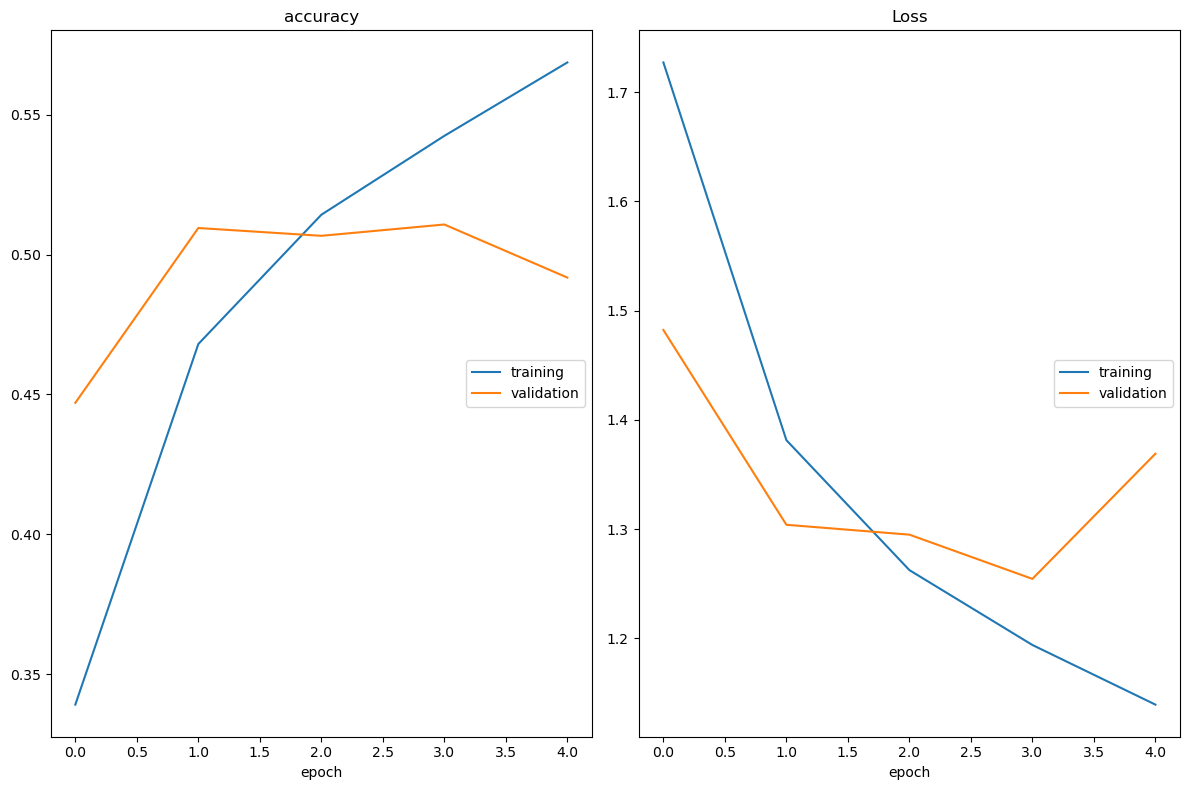

accuracy
	training         	 (min:    0.339, max:    0.569, cur:    0.569)
	validation       	 (min:    0.447, max:    0.511, cur:    0.492)
Loss
	training         	 (min:    1.139, max:    1.727, cur:    1.139)
	validation       	 (min:    1.254, max:    1.482, cur:    1.369)

Epoch 5: val_accuracy did not improve from 0.51074
448/448 [==============================] - 807s 2s/step - loss: 1.1393 - accuracy: 0.5687 - val_loss: 1.3690 - val_accuracy: 0.4918 - lr: 0.0010


In [5]:
epochs=5
steps_per_epoch=train_generator.n//train_generator.batch_size
validations_step=validation_generator.n//validation_generator.batch_size
checkpoint=ModelCheckpoint("model_weight.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1,save_best_only=True)
reduce_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,min_lr=0.00001,model='auto')
callbacks=[PlotLossesKeras(),checkpoint,reduce_lr]
history=model.fit(x=train_generator,steps_per_epoch=steps_per_epoch,epochs=epochs,validation_data=validation_generator,
                 validation_steps=validations_step,callbacks=callbacks)


In [7]:
model_json=model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)